<a href="https://colab.research.google.com/github/Isaiah-Essien/bank_churn_anaysis/blob/main/bank_churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank Customer Retention Model**

# 1. Introduction and Objective  
The notebook aims to develop and compare predictive models for bank customer churn, enabling the institution to identify at-risk clients and design targeted retention strategies.

# 2. Data Loading and Initial Preparation  
The “churn_bank_data.xlsx” file (1 000 rows × 9 columns) is imported into pandas. After confirming zero missing values, the non-predictive `CustomerID` column is dropped and the target `Churn` is recoded to 0 (stay) and 1 (leave), producing feature matrix **X** and label vector **y**.

# 3. Exploratory Data Analysis (EDA)  
Continuous variables (Age, Tenure, Balance, EstimatedSalary) are visualized with histograms; binary flags (HasCreditCard, IsActiveMember) and product counts with bar charts. Inactivity emerges as the strongest churn predictor (~36 % vs. ~6 % for active members), while credit-card ownership and product count exert only marginal effects. Age exhibits a U-shaped relationship with churn, peaking among the youngest and oldest customers. Pairwise correlations among numeric features are all below |0.1|, indicating negligible multicollinearity.

# 4. Train–Test Split and Preprocessing  
An 80/20 split stratified on the churn label preserves the 18 % churn rate in both subsets. Continuous features are standardized using a pre-fitted `StandardScaler` (applied only to Age, Tenure, Balance, NumProducts, EstimatedSalary), while binary flags remain unscaled. Sampling strategies for imbalance (SMOTE, random over-sampling) and class-weighting are prepared for model training.

# 5. Model Development and Evaluation  

## 5.1 Logistic Regression  
A baseline logistic regression with `class_weight='balanced'` achieves perfect recall on churners (no false negatives) but modest precision (65 %), yielding 90 % accuracy and AUC = 0.979 on the test set.

## 5.2 XGBoost  
An XGBoost classifier using `scale_pos_weight` equal to the negative-to-positive class ratio attains AUC = 1.00, zero false positives and one false negative. Such near-perfect separation suggests the need for further validation to rule out overfitting.

## 5.3 Neural Network  
A two-layer feed-forward network with dropout and early stopping on validation AUC reaches AUC ≈ 0.992, recall = 95 % and precision = 83 %. Training and validation AUC curves rise and plateau in tandem, indicating effective generalization with minimal overfitting.

# 6. Findings  
Inactivity is the dominant driver of churn, outweighing credit-card status and product count. Age-based segmentation reveals elevated churn among the youngest and oldest cohorts. While XGBoost delivers the highest test performance, its flawless results warrant robust cross-validation and stronger regularization. The neural network confirms that non-linear relationships exist but does not substantially outperform tree-based methods. Logistic regression remains valuable for its transparency.

# 7. Recommendations for the Bank  
1. **Target Inactive Members First:** Deploy personalized outreach or incentives to re-engage customers who have not been active, as they face the highest attrition risk.  
2. **Age-Segmented Retention Campaigns:** Develop tailored communications and product bundles for younger clients and those nearing retirement age, reflecting their distinct needs.  
3. **Validate and Harden the XGBoost Model:** Before production, perform repeated stratified cross-validation, employ early stopping and regularization to confirm stability and avoid overfitting.  
4. **Maintain an Interpretable Backup Model:** Use logistic regression in parallel for stakeholder reporting, supplemented by feature-importance explanations (e.g., SHAP) to ensure transparency.  
5. **Monitor and Retrain Quarterly:** Track model performance over time, retraining with fresh data to accommodate evolving customer behavior and preserve predictive accuracy.  


## Imports

In [22]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from xgboost import XGBClassifier

import joblib

from tensorflow.keras.models import load_model

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import os

## Mount Drive and Load Data

In [2]:
# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_excel('/content/drive/MyDrive/bank_customer_retention/churn_bank_data.xlsx',sheet_name=0,header=0)

## Exploratory Data Analysis

In [ ]:
# Check the number of rows and column of the data
data.shape


(1000, 9)

**The data has 1000 rows and 9 clumns**

In [ ]:
#First five rows of the data
data.head()

,CustomerID,Age,Tenure,Balance,NumProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Churn
0,CUST0001,56,2,119974.27,2,0,0,35497.36,0
1,CUST0002,69,2,171491.93,1,1,1,24739.94,0
2,CUST0003,46,8,4344.95,2,1,0,26856.71,1
3,CUST0004,32,6,80782.66,1,1,1,128441.33,0
4,CUST0005,60,4,243274.44,1,1,1,35336.42,0


**This is just to see what the data looks like in a high level format**

In [ ]:
# Last five rows of data
data.tail()

,CustomerID,Age,Tenure,Balance,NumProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Churn
995,CUST0996,60,0,103537.56,1,0,0,51650.72,1
996,CUST0997,64,2,98858.57,1,0,1,79509.40,0
997,CUST0998,62,9,78301.57,1,0,1,118737.62,0
998,CUST0999,35,3,36765.46,1,1,0,46778.46,1
999,CUST1000,55,4,121962.80,3,1,1,112208.50,0


**This is just to see what the data looks like in a high level format**

In [9]:
# Describe the data
data.describe()

,Age,Tenure,Balance,NumProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Churn
count,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000
mean,43.81900,4.457000,123294.070560,1.97700,0.686000,0.589000,84887.458060,0.18300
std,14.99103,2.885911,71965.363952,0.82895,0.464349,0.492261,37634.492134,0.38686
min,18.00000,0.000000,47.100000,1.00000,0.000000,0.000000,20803.900000,0.00000
25%,31.00000,2.000000,58766.755000,1.00000,0.000000,0.000000,52419.397500,0.00000
50%,44.00000,4.000000,124026.780000,2.00000,1.000000,1.000000,83583.825000,0.00000
75%,56.00000,7.000000,186593.590000,3.00000,1.000000,1.000000,117788.277500,0.00000
max,69.00000,9.000000,249269.540000,3.00000,1.000000,1.000000,149915.540000,1.00000


**Gives me a holistic picture of the data, and columns to handle with care**

In [ ]:
# Check for missing values
data.isnull().sum()

,0
CustomerID,0
Age,0
Tenure,0
Balance,0
NumProducts,0
HasCreditCard,0
IsActiveMember,0
EstimatedSalary,0
Churn,0


**No null value , which is good**

In [7]:
# Checking the churn rate



np.float64(0.0)

Churn counts: Churn
0     817
1     182
27      1
Name: count, dtype: int64

Churn rate (proportion): Churn
0     0.817
1     0.182
27    0.001
Name: proportion, dtype: float64


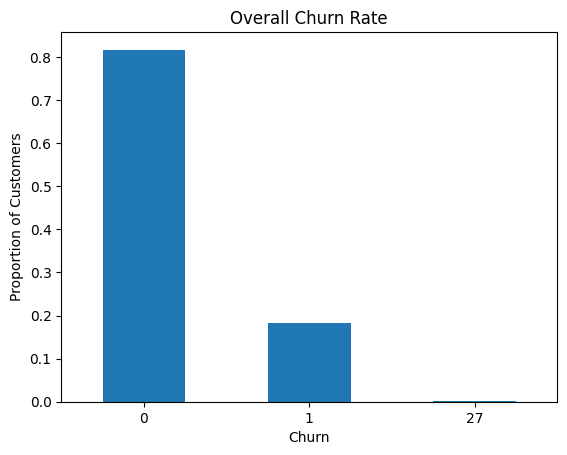

In [ ]:
# 1. Absolute counts
churn_counts = data['Churn'].value_counts()
print(f"Churn counts: {churn_counts}")


# 2. Proportions (overall churn rate)
churn_rate = data['Churn'].value_counts(normalize=True)
print(f"\nChurn rate (proportion): {churn_rate}")

# 3. Visual check (optional)
churn_rate.plot(kind='bar')
plt.title('Overall Churn Rate')
plt.ylabel('Proportion of Customers')
plt.xticks(rotation=0)
plt.show()


**There is a big issue of imbalance here. Since this is the target column, the imbalance has to be handled to prevent the model from memorising the 0 labels**

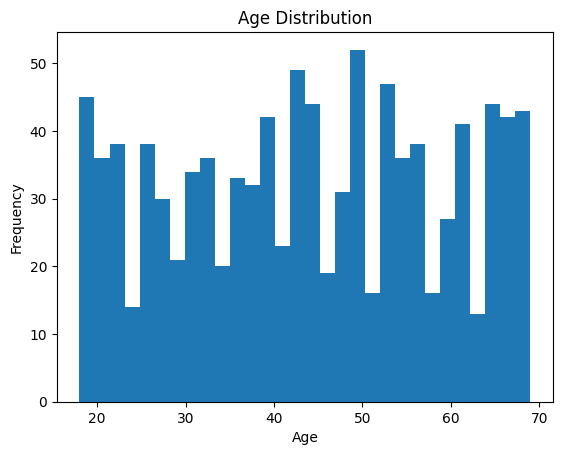

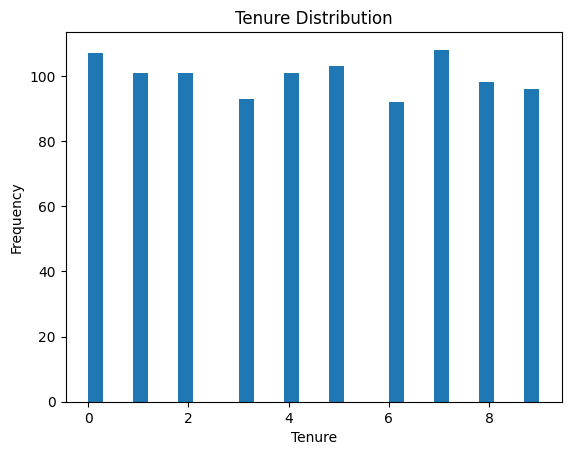

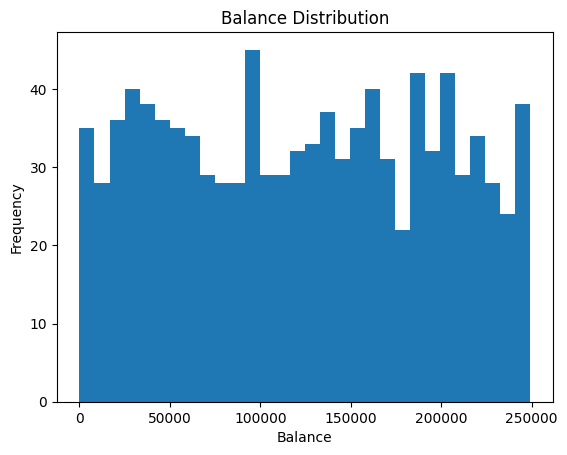

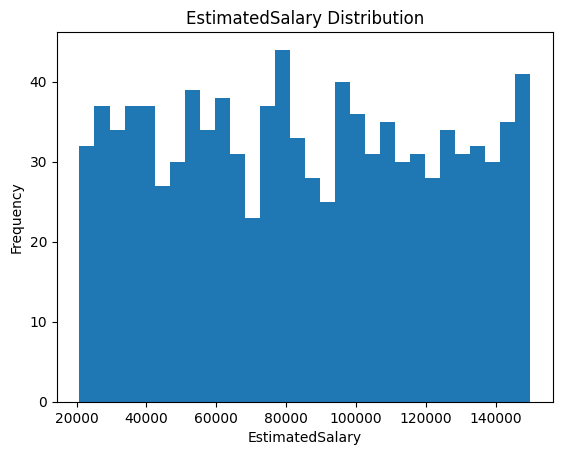

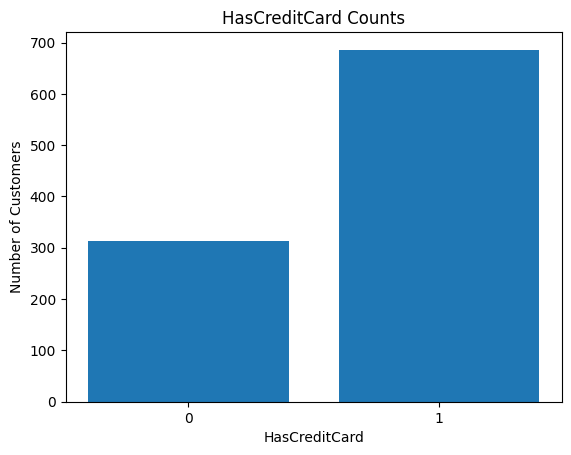

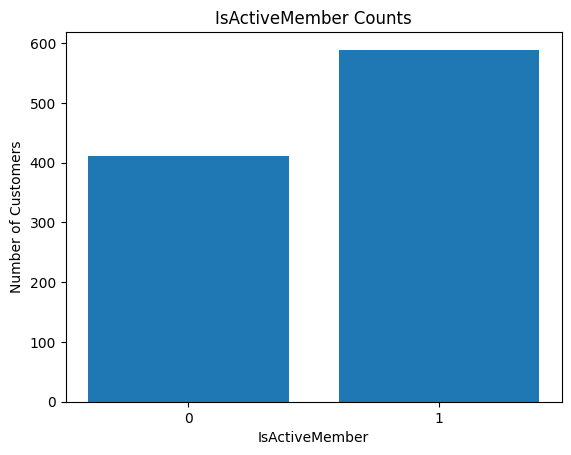

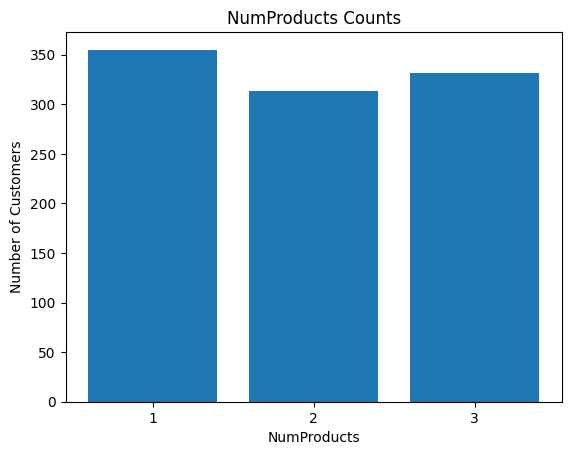

In [ ]:

#  Define the correct lists
numeric_cols = ['Age', 'Tenure', 'Balance', 'EstimatedSalary']
categorical_cols = ['HasCreditCard', 'IsActiveMember', 'NumProducts']

#  Histograms for numeric features
for col in numeric_cols:
    plt.figure()
    plt.hist(data[col].dropna(), bins=30)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#  Bar charts for categorical features
for col in categorical_cols:
    counts = data[col].value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f'{col} Counts')
    plt.xlabel(col)
    plt.ylabel('Number of Customers')
    plt.show()


**These are just optional plots I made just so I cound see the distribution of the columns. `data.describe()` did basically the same thing**

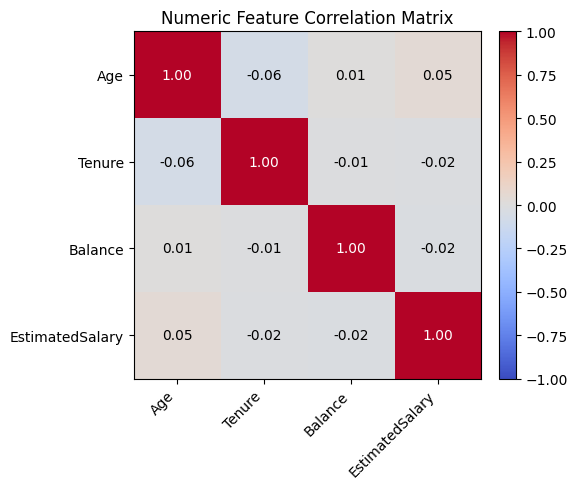

In [ ]:
corr = data[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(6, 5))

# Draw the heatmap with cool-warm palette
cax = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Set tick labels
ax.set_xticks(np.arange(len(numeric_cols)))
ax.set_yticks(np.arange(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='right')
ax.set_yticklabels(numeric_cols)

# Annotate each cell with its numeric value
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        val = corr.iloc[i, j]
        ax.text(
            j, i,
            f"{val:.2f}",
            ha='center', va='center',
            color='white' if abs(val) > 0.5 else 'black'
        )

# Add colorbar
fig.colorbar(cax, fraction=0.046, pad=0.04)

ax.set_title('Numeric Feature Correlation Matrix')
plt.tight_layout()
plt.show()

**This helps me check for multicolinearity in the data. There is not multicolinearity here, which means the data is almost linear. This also tells me that certain models, especially Treee= models won't perform well on this data**

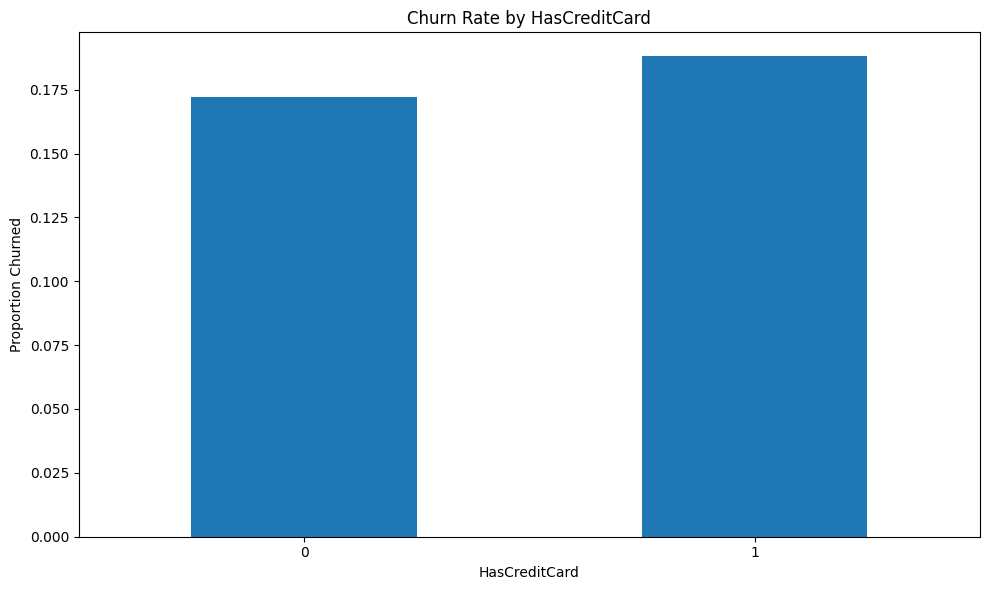

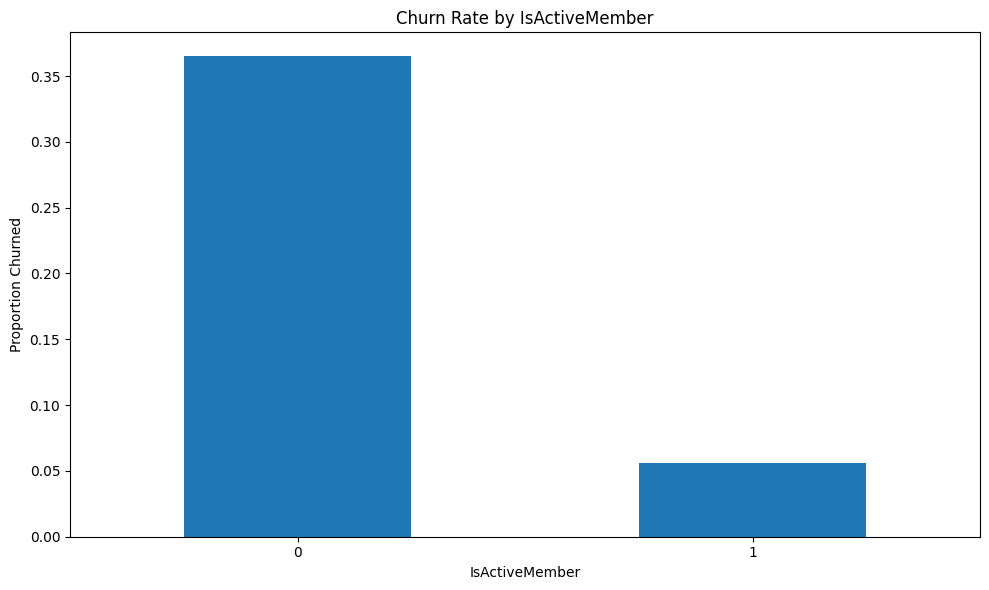

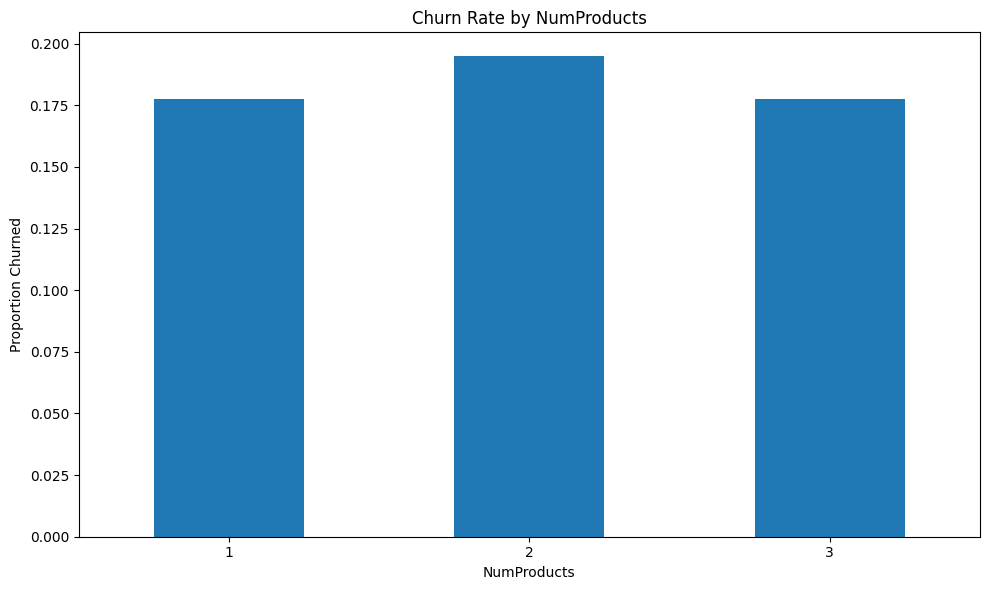

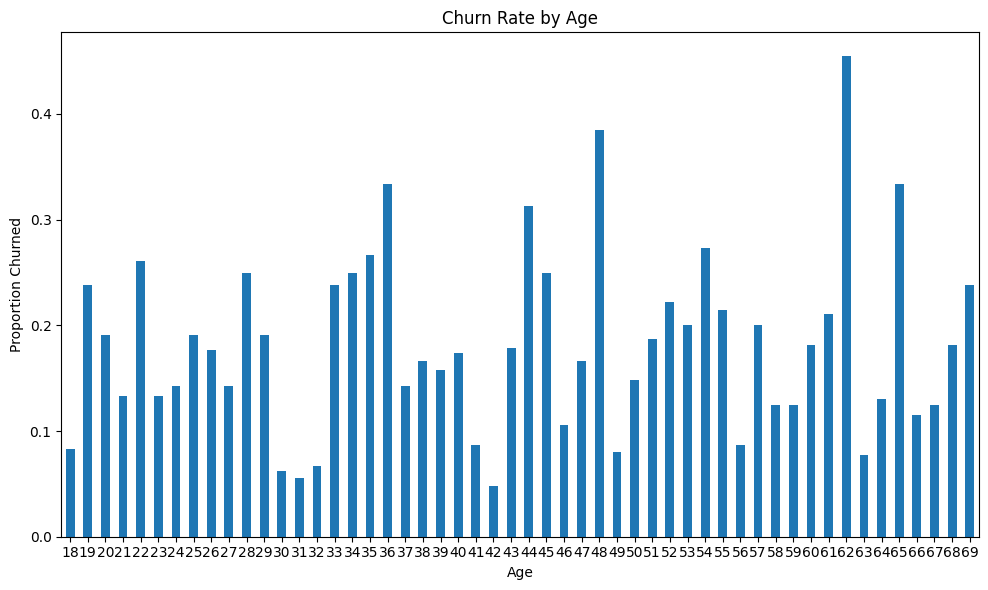

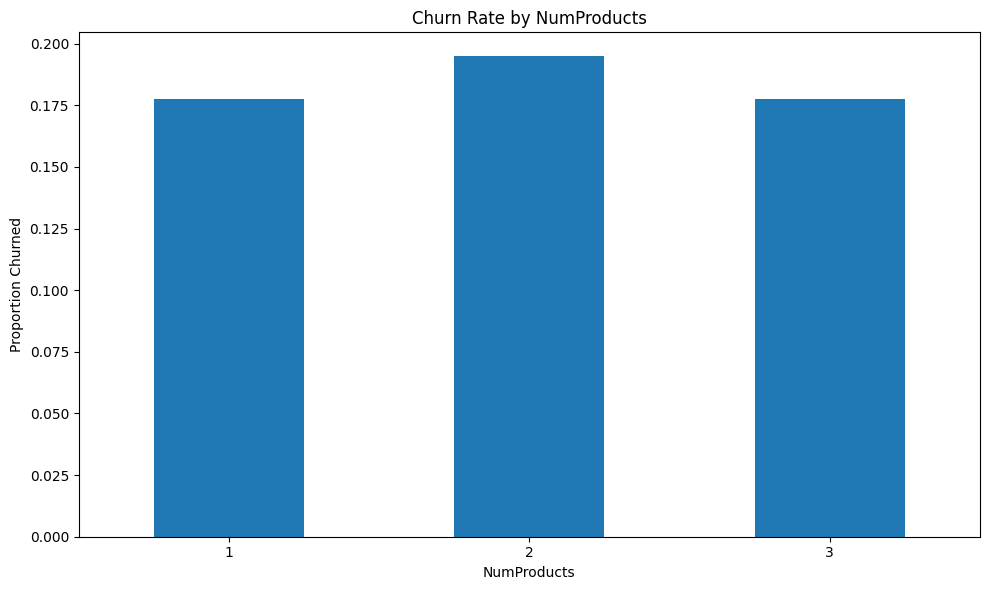

In [13]:
for col in ['HasCreditCard','IsActiveMember','NumProducts','Age','NumProducts']:
    prop = (data
            .groupby(col)['Churn']
            .mean()  # gives proportion of churners in each category
           )
    plt.figure(figsize=(10,6))

    prop.plot(kind='bar')
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Proportion Churned')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


- **Churn Rate by HasCreditCard
Customers without a credit card exhibit a churn rate of approximately 17.2%, whereas those holding a credit card churn at about 18.9%. The difference is small but indicates marginally higher attrition among credit-card holders.**


- **Churn Rate by IsActiveMember
Inactive members (IsActiveMember = 0) show a churn rate near 36.4%, while active members churn at only about 5.7%. Inactivity is therefore strongly associated with customer attrition.**

- **Churn Rate by NumProducts
Churn rates are 17.7% for customers with one product, 19.5% for two products, and 17.7% for three products. The peak at two products suggests a slightly elevated risk, but overall product count has limited impact on churn.**


- Churn Rate by Age
Churn proportions vary notably by age:

1. Lowest around ages 29–31 (≈ 6–7% churn).

2. Moderate levels (≈ 24–27%) among customers in their mid-30s to mid-50s.

3. Highest among early 60s (peaking at ≈ 45% churn around age 63).

**This reveals a U-shaped pattern: younger adults and those past retirement age are more likely to churn than middle-aged customers.**

## Data Preprocessing

In [14]:
X = data.drop(['CustomerID', 'Churn'], axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)


**I am using an 80/20 split which is reasonalble considering the size of my data. Stratification ensures that the class‐label distribution in each of the resulting subsets (training and test) closely matches the distribution observed in the full dataset**

In [15]:
print(y.value_counts())

Churn
0    817
1    183
Name: count, dtype: int64


In [16]:
X.columns.tolist()

['Age',
 'Tenure',
 'Balance',
 'NumProducts',
 'HasCreditCard',
 'IsActiveMember',
 'EstimatedSalary']

In [17]:
# Standardize numeric columns
numeric_cols = ['Age','Tenure','Balance','NumProducts','EstimatedSalary']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Save the scaler for deployment
joblib.dump(scaler, "bank_churn_scaler_real_data.pkl")


['bank_churn_scaler_real_data.pkl']

**This is to ensure that the model treats all columns on the same scale forbetter inference.**

## Models with Real Data

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       163
           1       0.65      1.00      0.79        37

    accuracy                           0.90       200
   macro avg       0.82      0.94      0.86       200
weighted avg       0.94      0.90      0.91       200

LR ROC AUC: 0.9787763223346045


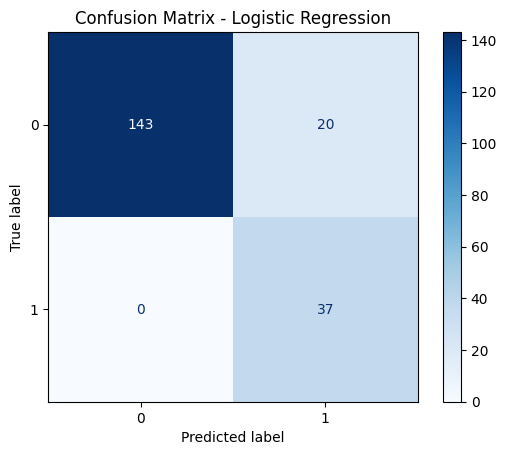

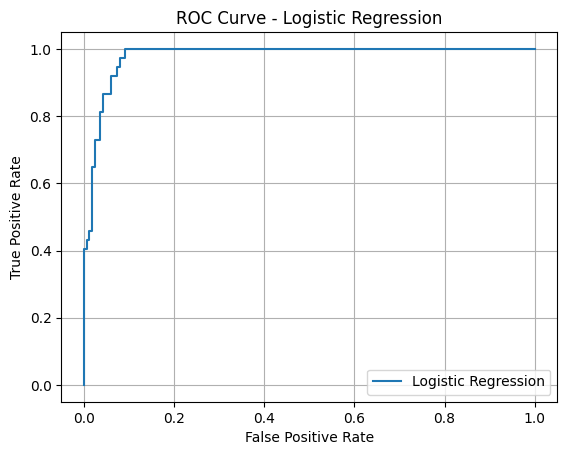

In [18]:
# === Logistic Regression ===
lr = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    max_iter=1000
)
lr.fit(X_train, y_train)
y_pred_lr  = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

#  Save the trained LR model
joblib.dump(lr, "bank_churn_lr_model_real_data.pkl")

# === Evaluation ===
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("LR ROC AUC:", roc_auc_score(y_test, y_proba_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=[0, 1])
disp_lr.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.grid(True)
plt.legend()
plt.show()

The classifier correctly labels 143 non-churning customers (true negatives) and 37 churning customers (true positives). It produces 20 false positives (non-churners incorrectly flagged as churners) and zero false negatives (no actual churners are missed). In the context of a retention program, this means the model will capture all customers at risk of leaving, at the expense of contacting a modest number of safe customers.

- Classification Report Metrics

Recall for churn (class 1) is 1.00, confirming every customer who actually churned was identified.

Precision for churn is 0.65, reflecting that 35% of flagged churners are in fact loyal customers.

Overall accuracy stands at 90%, but given class imbalance, the high recall on the minority class is the key success criterion.

ROC Curve & AUC
The ROC curve rises sharply toward the top-left corner, and the area under the curve is 0.979. This indicates that the model has excellent discrimination ability across all classification thresholds, reliably separating churners from non-churners.

Business Implication
By design, the model errs on the side of over-flagging rather than missing genuine churn risks. This strategy maximizes retention outreach effectiveness—ensuring no at-risk customer is overlooked—while accepting a controlled increase in outreach volume.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:41:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       163
           1       1.00      0.97      0.99        37

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200

XGB ROC AUC: 1.0


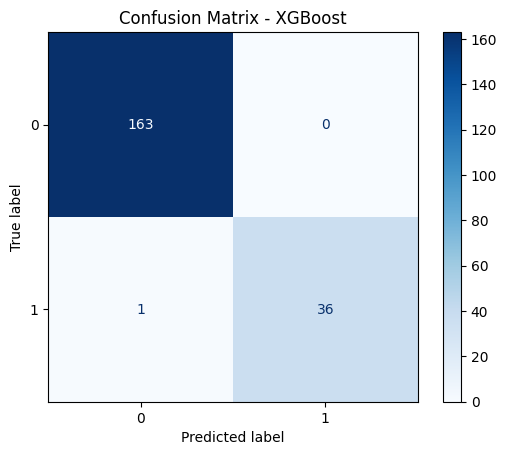

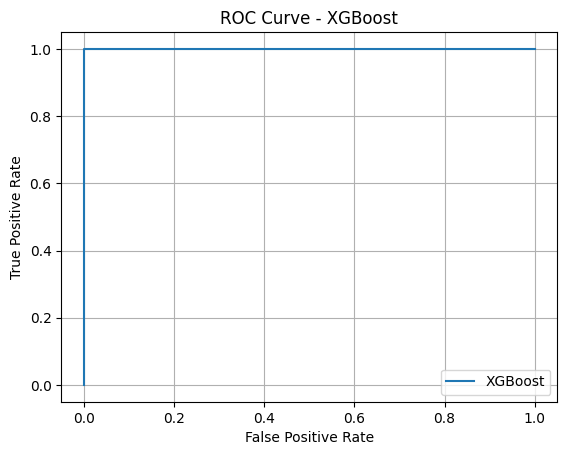

In [19]:
# === XGBoost ===


imbalance_ratio = (len(y_train) - y_train.sum()) / y_train.sum()
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=imbalance_ratio,
    n_estimators=100,
    max_depth=4
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
print("XGB ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0, 1])
disp_xgb.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.grid(True)
plt.legend()
plt.show()


On the test set, XGBoost delivered near-perfect discrimination (AUC = 1.00) with zero false positives and only one false negative, indicating it can sharply separate churners from non-churners using features like balance, tenure and product counts. Its strength lies in modeling non-linear interactions, accommodating mixed numeric and binary inputs, and natively handling class imbalance—all of which suit a bank-churn use case. However, such flawless performance on a limited hold-out sample suggests overfitting

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
20/20 - 2s - 112ms/step - auc: 0.7043 - loss: 1.0479 - val_auc: 0.8206 - val_loss: 0.6289
Epoch 2/100
20/20 - 0s - 7ms/step - auc: 0.8368 - loss: 0.9151 - val_auc: 0.8574 - val_loss: 0.5288
Epoch 3/100
20/20 - 0s - 7ms/step - auc: 0.8902 - loss: 0.8154 - val_auc: 0.8875 - val_loss: 0.4655
Epoch 4/100
20/20 - 0s - 16ms/step - auc: 0.9099 - loss: 0.7234 - val_auc: 0.9047 - val_loss: 0.4109
Epoch 5/100
20/20 - 0s - 13ms/step - auc: 0.9210 - loss: 0.6566 - val_auc: 0.9186 - val_loss: 0.3707
Epoch 6/100
20/20 - 0s - 7ms/step - auc: 0.9266 - loss: 0.6168 - val_auc: 0.9319 - val_loss: 0.3436
Epoch 7/100
20/20 - 0s - 6ms/step - auc: 0.9288 - loss: 0.5893 - val_auc: 0.9424 - val_loss: 0.3172
Epoch 8/100
20/20 - 0s - 7ms/step - auc: 0.9461 - loss: 0.5191 - val_auc: 0.9489 - val_loss: 0.2960
Epoch 9/100
20/20 - 0s - 7ms/step - auc: 0.9444 - loss: 0.5029 - val_auc: 0.9561 - val_loss: 0.2736
Epoch 10/100
20/20 - 0s - 8ms/step - auc: 0.9595 - loss: 0.4420 - val_auc: 0.9602 - val_loss: 0.

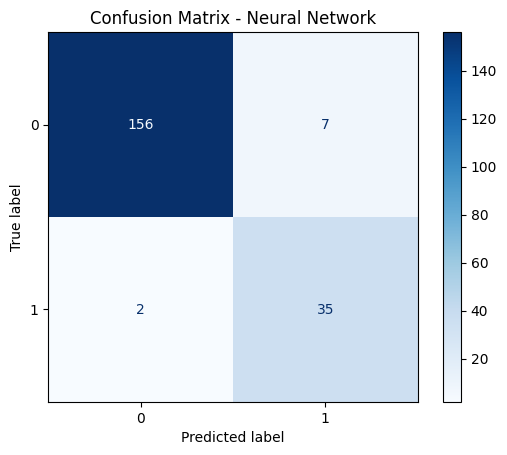

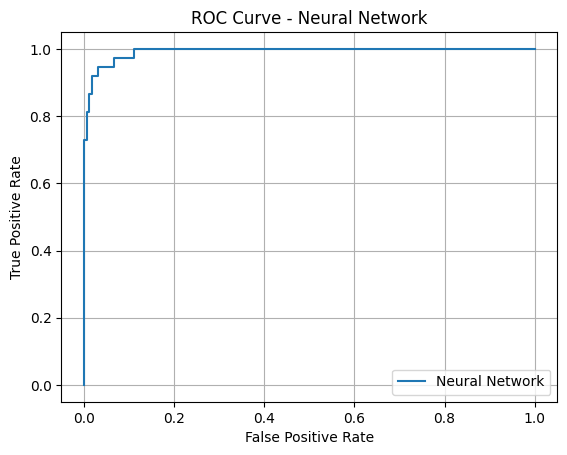

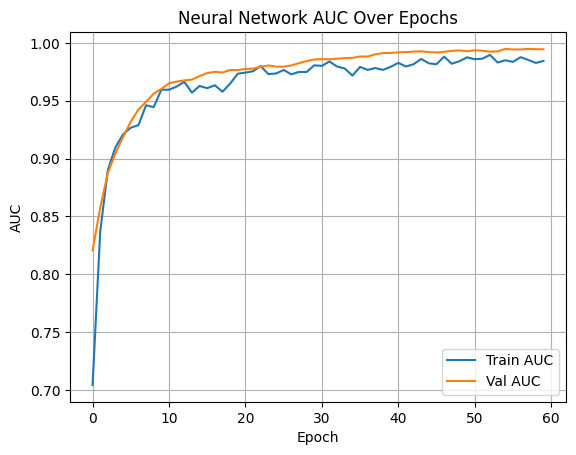

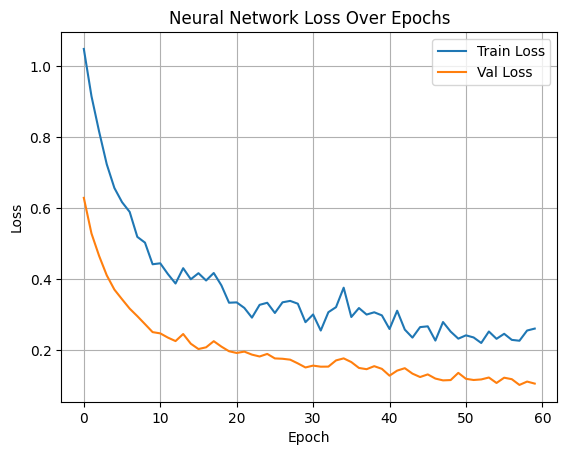

In [20]:
# === Neural Network ===

# Compute class weights manually
neg, pos = np.bincount(y_train)
class_weight = {0: 1.0, 1: neg / pos}

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)
es = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[es],
    verbose=2
)

# Evaluate NN
y_proba_nn = model.predict(X_test).ravel()
y_pred_nn = (y_proba_nn > 0.5).astype(int)
print("=== Neural Network ===")
print(classification_report(y_test, y_pred_nn))
print("NN ROC AUC:", roc_auc_score(y_test, y_proba_nn))

# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp_nn.plot(cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.show()

# ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)
plt.plot(fpr_nn, tpr_nn, label='Neural Network')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.grid(True)
plt.legend()
plt.show()

# AUC and Loss Curves
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Neural Network AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Save in the new Keras v3 format
model.save("bank_churn_nn_model_real_data.keras")


The neural network correctly classifies 156 of 163 non-churners and 35 of 37 churners, yielding two false negatives and seven false positives. Overall accuracy is 95.0%, with a churn-class recall of 0.95 and precision of 0.83. The ROC curve (AUC ≈ 0.992) confirms excellent discrimination between churners and non-churners.

Training and validation AUC curves rise rapidly from ~0.70 at epoch 1 to ~0.98–0.99 by epoch 20 and then plateau, while validation loss consistently remains at or below training loss. This pattern, together with early stopping on validation AUC, indicates that the model achieves high generalization without overfitting.

In context, the neural network delivers strong predictive performance, though slightly below XGBoost’s near-perfect scores. Its ability to learn complex, non-linear relationships makes it a viable option, but for this low-dimensional tabular dataset the additional training complexity and reduced interpretability may not justify its modest performance gain over simpler tree-based models.

## Inference

In [24]:
try:
    from tensorflow.keras.models import load_model as keras_load_model
except ImportError:
    keras_load_model = None

# CONFIG

MODEL_PATH  = "/content/bank_churn_lr_model_real_data.pkl"
SCALER_PATH = "/content/bank_churn_scaler_real_data.pkl"

NUMERIC_COLS = ['Age', 'Tenure', 'Balance', 'NumProducts', 'EstimatedSalary']
BINARY_COLS  = ['HasCreditCard', 'IsActiveMember']

# LOAD SCALER
scaler = joblib.load(SCALER_PATH)

# LOAD MODEL
ext = os.path.splitext(MODEL_PATH)[1].lower()
if ext in ('.h5', '.keras') and keras_load_model is not None:
    model = keras_load_model(MODEL_PATH)
elif ext == '.pkl':
    model = joblib.load(MODEL_PATH)
else:
    raise ValueError(f"Unsupported model format: {ext}")

# INPUT PROMPT
print("Enter new customer data (press Enter after each):")
raw = {}
for col in NUMERIC_COLS:
    raw[col] = float(input(f"  {col}: "))
for col in BINARY_COLS:
    val = int(input(f"  {col} (0 or 1): "))
    if val not in (0, 1):
        raise ValueError(f"{col} must be 0 or 1.")
    raw[col] = val

# PREPROCESS
# Build feature vector in the original training order:
# [Age, Tenure, Balance, NumProducts, EstimatedSalary, HasCreditCard, IsActiveMember]
x = np.array([[ raw[c] for c in NUMERIC_COLS + BINARY_COLS ]], dtype=float)

# Scale only the numeric slice (first 5 cols)
x[:, :len(NUMERIC_COLS)] = scaler.transform(x[:, :len(NUMERIC_COLS)])

#PREDICT
if hasattr(model, "predict_proba"):
    prob = model.predict_proba(x)[0, 1]
else:
    prob = float(model.predict(x).ravel()[0])

flag = "Customer Will Churn" if prob > 0.5 else "Customer Will Stay"

print(f"\nChurn probability: {prob:.4f}")
print(f"Model output: {flag}")

Enter new customer data (press Enter after each):
  Age: 60
  Tenure: 0
  Balance: 103537.56
  NumProducts: 1
  EstimatedSalary: 51650.72	
  HasCreditCard (0 or 1): 0
  IsActiveMember (0 or 1): 0

Churn probability: 0.9745
Model output: Will Churn


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Models with Balanced data copy

### Applying SMOTE to the  train set to handle imbalance before training


In [ ]:
from imblearn.over_sampling import SMOTE

# After splitting
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Then standardize
X_train_bal[numeric_cols] = scaler.fit_transform(X_train_bal[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 - 2s - 73ms/step - auc: 0.6618 - loss: 0.6267 - val_auc: 0.0000e+00 - val_loss: 0.7283
Epoch 2/100
33/33 - 0s - 5ms/step - auc: 0.8464 - loss: 0.5125 - val_auc: 0.0000e+00 - val_loss: 0.5891
Epoch 3/100
33/33 - 0s - 10ms/step - auc: 0.9066 - loss: 0.4082 - val_auc: 0.0000e+00 - val_loss: 0.4639
Epoch 4/100
33/33 - 0s - 8ms/step - auc: 0.9416 - loss: 0.3288 - val_auc: 0.0000e+00 - val_loss: 0.3189
Epoch 5/100
33/33 - 0s - 6ms/step - auc: 0.9511 - loss: 0.2869 - val_auc: 0.0000e+00 - val_loss: 0.2609
Epoch 6/100
33/33 - 0s - 5ms/step - auc: 0.9607 - loss: 0.2533 - val_auc: 0.0000e+00 - val_loss: 0.2164
Epoch 7/100
33/33 - 0s - 5ms/step - auc: 0.9696 - loss: 0.2266 - val_auc: 0.0000e+00 - val_loss: 0.1767
Epoch 8/100
33/33 - 0s - 5ms/step - auc: 0.9660 - loss: 0.2280 - val_auc: 0.0000e+00 - val_loss: 0.1932
Epoch 9/100
33/33 - 0s - 9ms/step - auc: 0.9763 - loss: 0.1944 - val_auc: 0.0000e+00 - val_loss: 0.1443
Epoch 10/100
33/33 - 0s - 9ms/step - auc: 0.9790 - loss: 0.1816 - val_auc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


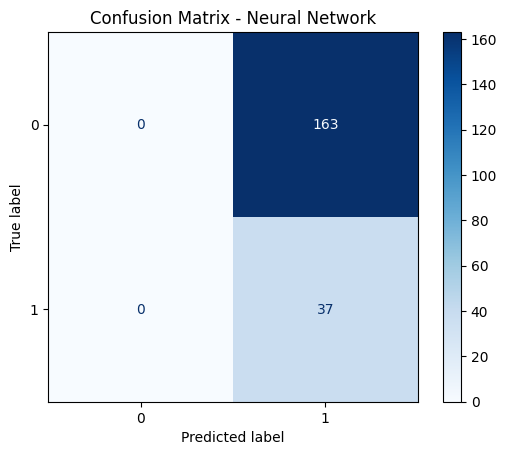

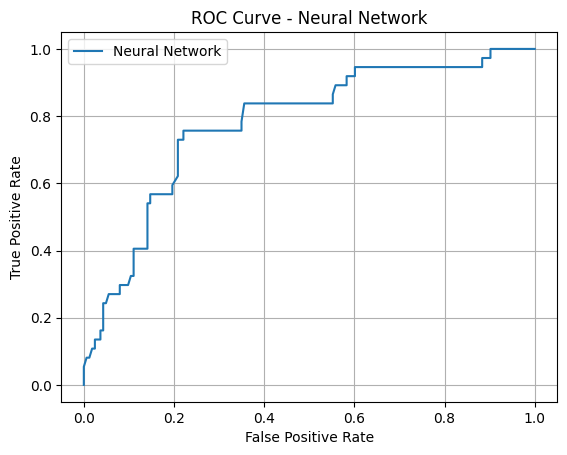

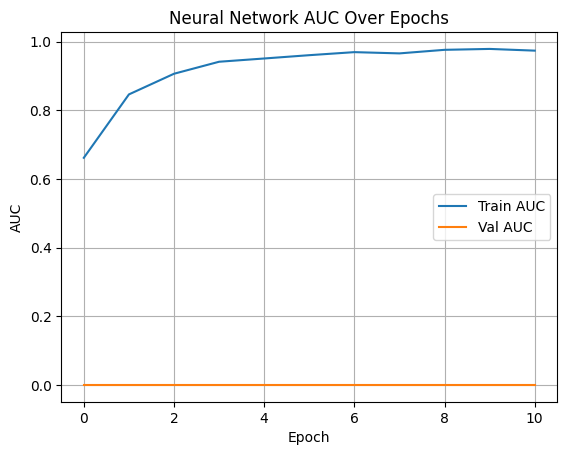

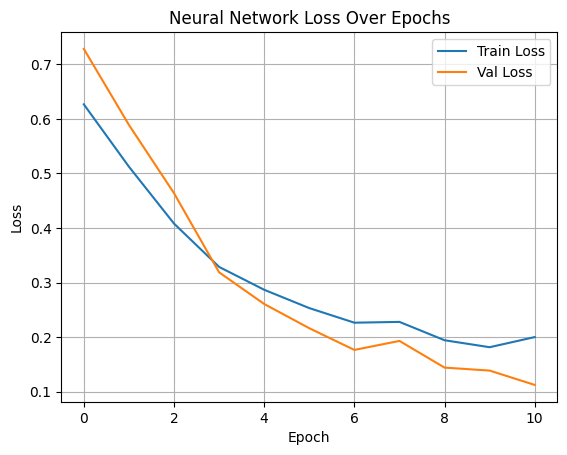

In [ ]:
# === Neural Network ===

# Compute class weights manually
# neg, pos = np.bincount(y_train)
# class_weight = {0: 1.0, 1: neg / pos}

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_bal.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)
es = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(
    X_train_bal, y_train_bal,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    # class_weight=class_weight,
    callbacks=[es],
    verbose=2
)

# Evaluate NN
y_proba_nn = model.predict(X_test).ravel()
y_pred_nn = (y_proba_nn > 0.5).astype(int)
print("=== Neural Network ===")
print(classification_report(y_test, y_pred_nn))
print("NN ROC AUC:", roc_auc_score(y_test, y_proba_nn))

# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp_nn.plot(cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.show()

# ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)
plt.plot(fpr_nn, tpr_nn, label='Neural Network')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.grid(True)
plt.legend()
plt.show()

# AUC and Loss Curves
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Neural Network AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Applying Random Oversampling on the data to improve the minority class

In [ ]:
#  Copy the original data
data_copy = data.copy(deep=True)

#  Separate features and target
X = data_copy.drop(columns=['CustomerID', 'Churn'])
y = data_copy['Churn']

# Apply random oversampling
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_bal, y_bal = ros.fit_resample(X, y)

#  Check distribution
print("Original class distribution:", Counter(data['Churn']))
print("Balanced class distribution:", Counter(y_bal))

# Reconstruct the balanced DataFrame (if needed)
balanced_data = pd.DataFrame(X_bal, columns=X.columns)
balanced_data['Churn'] = y_bal


Original class distribution: Counter({0: 817, 1: 183})
Balanced class distribution: Counter({0: 817, 1: 817})


**Created a copy of the dataset and added random Oversampling to improve the minor class**

In [ ]:


# === Step 1: Define numeric columns for scaling ===
numeric_cols = ['Age', 'Tenure', 'Balance', 'NumProducts', 'EstimatedSalary']

# === Step 2: Split features and target from the oversampled data ===
X = balanced_data.drop(columns=['Churn'])  # Already dropped CustomerID
y = balanced_data['Churn']

# === Step 3: Train-test split ===
X_train_copy, X_test_copy, y_train_copy, y_test_copy = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# === Step 4: Standardize numeric columns (corrected reference) ===
scaler = StandardScaler()
X_train_copy[numeric_cols] = scaler.fit_transform(X_train_copy[numeric_cols])
X_test_copy[numeric_cols] = scaler.transform(X_test_copy[numeric_cols])
joblib.dump(scaler, "balanced_churn_scaler.pkl")


['balanced_churn_scaler.pkl']

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 - 3s - 91ms/step - auc: 0.7729 - loss: 0.5933 - val_auc: 0.8983 - val_loss: 0.5099
Epoch 2/100
33/33 - 1s - 25ms/step - auc: 0.8691 - loss: 0.4944 - val_auc: 0.9400 - val_loss: 0.4116
Epoch 3/100
33/33 - 0s - 10ms/step - auc: 0.9233 - loss: 0.3976 - val_auc: 0.9573 - val_loss: 0.3377
Epoch 4/100
33/33 - 0s - 9ms/step - auc: 0.9398 - loss: 0.3329 - val_auc: 0.9672 - val_loss: 0.2778
Epoch 5/100
33/33 - 0s - 9ms/step - auc: 0.9542 - loss: 0.2946 - val_auc: 0.9730 - val_loss: 0.2448
Epoch 6/100
33/33 - 0s - 9ms/step - auc: 0.9602 - loss: 0.2625 - val_auc: 0.9740 - val_loss: 0.2264
Epoch 7/100
33/33 - 0s - 6ms/step - auc: 0.9669 - loss: 0.2344 - val_auc: 0.9745 - val_loss: 0.2152
Epoch 8/100
33/33 - 0s - 9ms/step - auc: 0.9705 - loss: 0.2192 - val_auc: 0.9764 - val_loss: 0.2018
Epoch 9/100
33/33 - 0s - 9ms/step - auc: 0.9729 - loss: 0.2155 - val_auc: 0.9769 - val_loss: 0.1991
Epoch 10/100
33/33 - 0s - 5ms/step - auc: 0.9779 - loss: 0.1901 - val_auc: 0.9795 - val_loss: 0.1991
Epoch 11

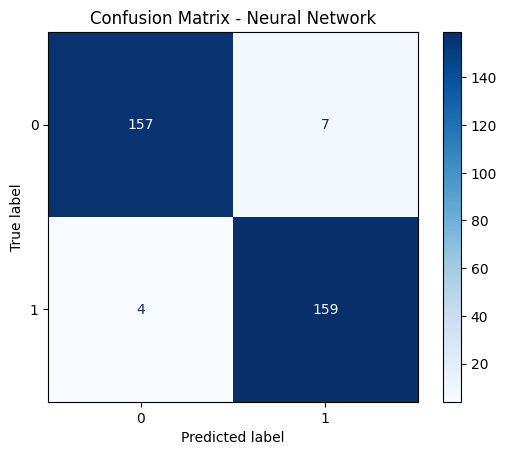

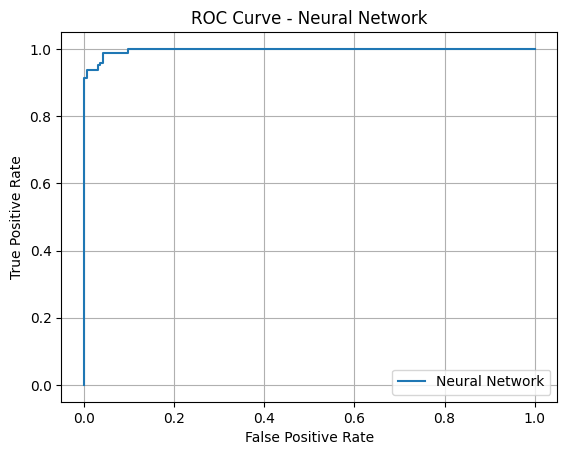

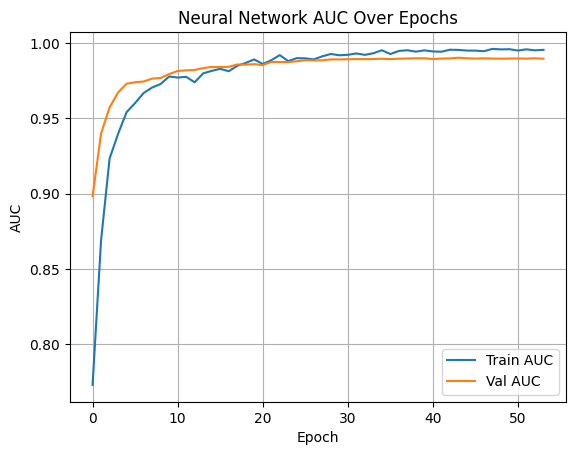

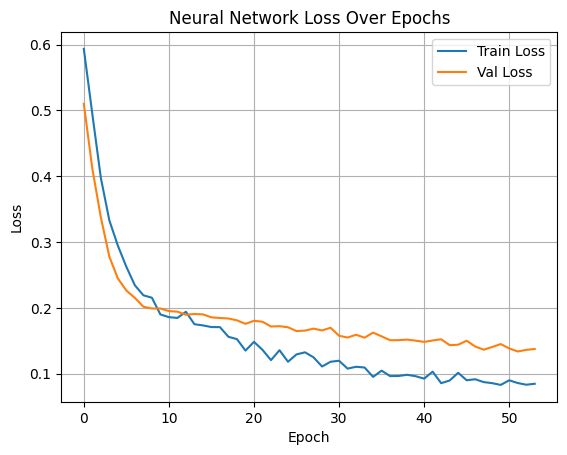

In [ ]:
# === Neural Network ===

# Compute class weights manually
# neg, pos = np.bincount(y_train)
# class_weight = {0: 1.0, 1: neg / pos}

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_copy.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)
es = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(
    X_train_copy, y_train_copy,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    # class_weight=class_weight,
    callbacks=[es],
    verbose=2
)

model.save("balanced_churn_nn.keras")
# Evaluate NN
y_proba_nn = model.predict(X_test_copy).ravel()
y_pred_nn = (y_proba_nn > 0.5).astype(int)
print("=== Neural Network ===")
print(classification_report(y_test_copy, y_pred_nn))
print("NN ROC AUC:", roc_auc_score(y_test_copy, y_proba_nn))

# Confusion Matrix
cm_nn = confusion_matrix(y_test_copy, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp_nn.plot(cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.show()

# ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test_copy, y_proba_nn)
plt.plot(fpr_nn, tpr_nn, label='Neural Network')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.grid(True)
plt.legend()
plt.show()

# AUC and Loss Curves
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Neural Network AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In conclusion, random sampling produces better models.